# Introduction
Author: Reuben Jooste (u21457060)

In this project we look at how we can use Data Mining techniques such as Sentiment Analysis and Topic Modelling, to extract insights from Amazon customers regarding the Software products and services offered. Analysing the reviews can reveal sentiment trends, trending topics/products, and what customers like and dislike, allowing the business to then make changes to their services to better fit customer needs which will lead to an
increase in customer satisfaction and potentially increased revenue for the company.

### Data:
We will use the *Software* customer reviews dataset created by Amazon. The dataset can be found at [this](https://amazon-reviews-2023.github.io) link and then scrolling down and selecting the Software dataset.

This dataset contains 4.8M records with the following attributes:

| Field | Type | Explanation |
| ----- | ---- | ----------- |
| rating | float | Rating of the product (from 1.0 to 5.0). |
| title | str | Title of the user review. |
| text | str | Text body of the user review. |
| images | list | Images that users post after they have received the product. Each image has different sizes (small, medium, large), represented by | the small_image_url, medium_image_url, and large_image_url respectively. |
| asin | str | ID of the product. |
| parent_asin | str | Parent ID of the product. Note: Products with different colors, styles, sizes usually belong to the same parent ID. The “asin” in previous Amazon datasets is actually parent ID. Please use parent ID to find product meta. |
| user_id | str | ID of the reviewer |
| timestamp | int | Time of the review (unix time) |
| verified_purchase | bool | User purchase verification |
| helpful_vote | int | Helpful votes of the review |

Furthermore, we will use the corresponding META dataset to help clarify what the categories of the products are based on the *parent_asin* attribute.

### Approach:
**Sentiment Analysis:**

We will first preprocess the data to remove any stop words, as well as apply tokenisation and lemmatisation techniques. Using a pre-trained model such as TextBlob, we will classify the processed subset of data as positive, negative, or neutral and label the data. Based on the labelled data we will then analyse the sentiment trends by product ratings, time, and purchase verification. 

**Topic Modelling:**

We will apply similar preprocessing techniques as the sentiment analysis approach, with an emphasis on text cleaning. This will remove any special characters and irrelevant content. Using the Latent Dirichlet Allocation (LDA), we will extract the key topics from all the reviews. Based on the extracted topics, we can when examine the distribution across different product ratings as well as track how certain topics got more popular or less popular over time.

### Evaluation:
**Sentiment Analysis:**
- We will compare the *sentiment polarity* with the *review rating* to measure whether the sentiment predictions were accurate or not. 
- We will use time-series plots to measure if a product’s sentiment improved over time. 

**Topic Modelling:**
- We will use *coherence scores* to evaluate the topics generated by the LDA algorithm. 
- Distribution plots will also be used to verify whether meaningful patterns emerge e.g. if praising comments are concentrated in highly-rated reviews. 

*Baseline:* We will assume that reviews with low ratings (below 3) correspond to negative sentiment and vice versa.

# Libraries
This section contains all required libraries and packages.

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from textblob import TextBlob
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Ensure the required NLTK resources downloaded
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from scipy import stats

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Preprocessing
In this section we preprocess the data to ensure it is clean of any erroneous data (e.g. missing values, duplicates, etc.). We will also explore the dataset using descriptive statistics and other methods to better understand the content and structure of the dataset.

In [3]:
# reading the JSON data using json.load()
file_path = '/kaggle/input/cos781-amazon-software-reviews/Software.jsonl'
data = pd.read_json(file_path, lines=True)
data.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,1,malware,mcaffee IS malware,[],B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False
1,5,Lots of Fun,I love playing tapped out because it is fun to...,[],B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,[],B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True
3,4,Fun game,One of my favorite games,[],B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,[],B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True


In [72]:
# load meta data
meta_data = pd.read_json('/kaggle/input/cos781-amazon-software-reviews/meta_Software.jsonl', lines=True)
meta_data.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Appstore for Android,Accupressure Guide,3.6,NaN,[All the pressing point has been explained wit...,[Acupressure technique is very ancient and ver...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",mAppsguru,[],"{'Release Date': '2015', 'Date first listed on...",B00VRPSGEO,NaN,NaN,NaN
1,Appstore for Android,Ankylosaurus Fights Back - Smithsonian's Prehi...,4.0,NaN,[ENCOURAGE literacy skills with highlighted na...,[Join Ankylosaurus in this interactive book ap...,2.99,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]","Oceanhouse Media, Inc",[],"{'Release Date': '2014', 'Date first listed on...",B00NWQXXHQ,NaN,NaN,NaN
2,Appstore for Android,Mahjong 2015,3.1,NaN,[Mahjong 2015 is a free solitaire matching gam...,[Mahjong 2015 is a free solitaire matching gam...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",sophiathach,[],"{'Release Date': '2014', 'Date first listed on...",B00RFKP6AC,NaN,NaN,NaN
3,Appstore for Android,Jewels Brick Breakout,4.2,NaN,"[Game Features:, - Intuitive touch controls wi...",[Jewels Brick Breakout is a glowing jewels bri...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Bad Chicken,[],"{'Release Date': '2015', 'Date first listed on...",B00SP2QU0E,NaN,NaN,NaN
4,Appstore for Android,Traffic Police: Off-Road Cub,3.3,NaN,"[In this game you will find:, - Killer police ...",[Become the best road police officer in Cube C...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Dast 2 For Metro,[],"{'Release Date': '2016', 'Date first listed on...",B01DZIT64O,NaN,NaN,NaN


### Feature Engineering
We now have both the reviews and their meta data but we do not know the category of the products in our reviews dataset. Therefore, we use the parent_asin attribute in each dataset to create a new product category attribute in our reviews dataset.

In [73]:
merged_df = pd.merge(data, meta_data, on='parent_asin', how='left')
merged_df.head()

,rating,title_x,text,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase,main_category,...,description,price,images,videos,store,categories,details,bought_together,subtitle,author
0,1,malware,mcaffee IS malware,B07BFS3G7P,B0BQSK9QCF,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,2019-07-03 19:37:12.076,0,False,Software,...,[All-in-one online protection for your persona...,34.99,[{'thumb': 'https://m.media-amazon.com/images/...,"[{'title': 'McAfee REAL Support', 'url': 'http...",McAfee,"[Software, Antivirus & Security, Internet Secu...",{'Product Dimensions': '7.5 x 5.5 x 0.5 inches...,NaN,NaN,NaN
1,5,Lots of Fun,I love playing tapped out because it is fun to...,B00CTQ6SIG,B00CTQ6SIG,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2015-02-16 20:58:56.000,0,True,Appstore for Android,...,[THIS GAME IS LIFE-RUININGLY FUN!From the writ...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Electronic Arts,[],"{'Release Date': '2013', 'Date first listed on...",NaN,NaN,NaN
2,5,Light Up The Dark,I love this flashlight app! It really illumin...,B0066WJLU6,B0066WJLU6,AHSPLDNW5OOUK2PLH7GXLACFBZNQ,2013-03-04 12:14:27.000,0,True,Appstore for Android,...,"[There are many flashlight apps, so why get th...",0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",smallte.ch,[],"{'Release Date': '2011', 'Date first listed on...",NaN,NaN,NaN
3,4,Fun game,One of my favorite games,B00KCYMAWK,B00KCYMAWK,AH6CATODIVPVUOJEWHRSRCSKAOHA,2019-06-20 20:10:28.662,0,True,Appstore for Android,...,[Experience the best WMS & Bally slot games wi...,0.00,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': 'https://images-na.ssl-i...",SG Interactive,[],"{'Release Date': '2014', 'Date first listed on...",NaN,NaN,NaN
4,4,I am not that good at it but my kids are,Cute game. I am not that good at it but my kid...,B00P1RK566,B00P1RK566,AEINY4XOINMMJCK5GZ3M6MMHBN6A,2014-12-11 00:19:56.000,0,True,Appstore for Android,...,[SkyBalance by Nik Wallenda puts the legendary...,0.99,[{'large': 'https://m.media-amazon.com/images/...,"[{'title': '', 'url': '', 'user_id': ''}]",Tapinator,[],"{'Release Date': '2014', 'Date first listed on...",NaN,NaN,NaN


In [74]:
# we drop the following features since we do not need it for our analysis
merged_df.drop(['images', 'user_id', 'helpful_vote', 'average_rating', 'rating_number', 'features', 'description', 'price', 'videos', 'store', 'categories', 'details', 'bought_together', 'subtitle', 'author'], inplace=True, axis=1)
merged_df.head(2)

,rating,title_x,text,asin,parent_asin,timestamp,verified_purchase,main_category,title_y
0,1,malware,mcaffee IS malware,B07BFS3G7P,B0BQSK9QCF,2019-07-03 19:37:12.076,False,Software,"McAfee Total Protection 2022 [Old Version], 10..."
1,5,Lots of Fun,I love playing tapped out because it is fun to...,B00CTQ6SIG,B00CTQ6SIG,2015-02-16 20:58:56.000,True,Appstore for Android,The Simpsons: Tapped Out


In [82]:
# reorder columns
merged_df = merged_df[['main_category', 'title_x', 'title_y', 'text', 'asin', 'parent_asin', 'verified_purchase', 'rating', 'timestamp']]
merged_df.head(2)

,main_category,title_x,title_y,text,asin,parent_asin,verified_purchase,rating,timestamp
0,Software,malware,"McAfee Total Protection 2022 [Old Version], 10...",mcaffee IS malware,B07BFS3G7P,B0BQSK9QCF,False,1,2019-07-03 19:37:12.076
1,Appstore for Android,Lots of Fun,The Simpsons: Tapped Out,I love playing tapped out because it is fun to...,B00CTQ6SIG,B00CTQ6SIG,True,5,2015-02-16 20:58:56.000


In [80]:
merged_df.shape

(4880181, 9)

In [81]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880181 entries, 0 to 4880180
Data columns (total 9 columns):
 #   Column             Dtype         
---  ------             -----         
 0   rating             int64         
 1   title_x            object        
 2   text               object        
 3   asin               object        
 4   parent_asin        object        
 5   timestamp          datetime64[ns]
 6   verified_purchase  bool          
 7   main_category      object        
 8   title_y            object        
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 302.5+ MB


In [83]:
merged_df.describe()

,rating,timestamp
count,4.880181e+06,4880181
mean,3.935087e+00,2016-08-11 20:56:15.320964864
min,1.000000e+00,1999-03-15 04:02:39
25%,3.000000e+00,2014-09-03 01:27:03
50%,5.000000e+00,2016-03-19 18:49:49
75%,5.000000e+00,2018-08-15 19:51:14.231000064
max,5.000000e+00,2023-09-11 02:13:11.515000
std,1.451875e+00,NaN


In [84]:
merged_df.isnull().sum()

main_category        6245
title_x                 0
title_y                 0
text                    0
asin                    0
parent_asin             0
verified_purchase       0
rating                  0
timestamp               0
dtype: int64

In [87]:
# drop categories with no ID
merged_df.dropna(inplace=True)
merged_df.isnull().sum()

main_category        0
title_x              0
title_y              0
text                 0
asin                 0
parent_asin          0
verified_purchase    0
rating               0
timestamp            0
dtype: int64

In [89]:
# check duplicates
df = merged_df.copy()
# check duplicate rows
column_duplicates = df.duplicated().sum()
print(f'Total duplicate rows: {column_duplicates}')

Total duplicate rows: 51027


In [90]:
# drop duplicate rows
data_clean = merged_df.drop_duplicates()

In [91]:
# unique number of products
data_clean['parent_asin'].unique().shape

(87477,)

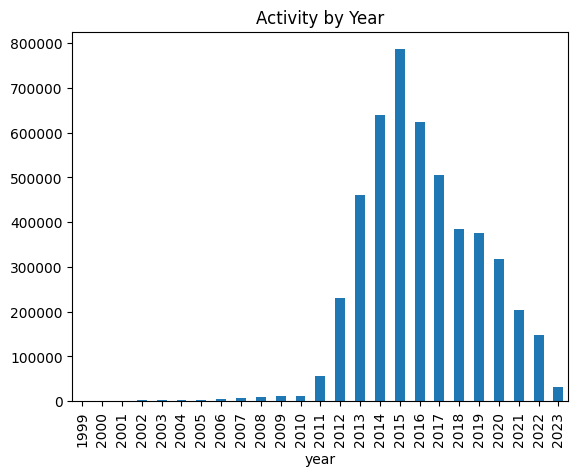

In [92]:
# analyse activity based on specific time (e.g. year, month, etc.)
def plot_timestamp(df, time_period):
    if time_period == 'year':
        df['year'].value_counts().sort_index().plot(kind='bar', title='Activity by Year')
    else:
        raise Exception('Invalid time period')

# Convert 'timestamp' from Unix time to datetime
df = data_clean.copy()
# Convert 'timestamp' from Unix time to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract the year from the 'datetime' column
df['year'] = df['datetime'].dt.year

# Extract the year from the 'datetime' column
df['year'] = df['datetime'].dt.year
plot_timestamp(df, 'year')

From the plot above we can see that there was a significant increase in product reviews from 2011 to 2015 and then decreased for the subsequent years. The raises questions such as *How did the sentiment change over the years?* or *What product were developed between these years that caused such a big difference in activity in terms of reviews?*

We will focus on the review between this 10 year (2012 - 2021) period.

### Filter data

In [93]:
df = data_clean.copy()
# Convert 'timestamp' from Unix time to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Extract the year from the 'datetime' column
df['year'] = df['datetime'].dt.year

# Filter dataset
filtered_data = df[(df['year'] >= 2012) & (df['year'] < 2022)]
filtered_data['year'].value_counts()

year
2015    786592
2014    639171
2016    623005
2017    505722
2013    461165
2018    385946
2019    376029
2020    318419
2012    229792
2021    203637
Name: count, dtype: int64

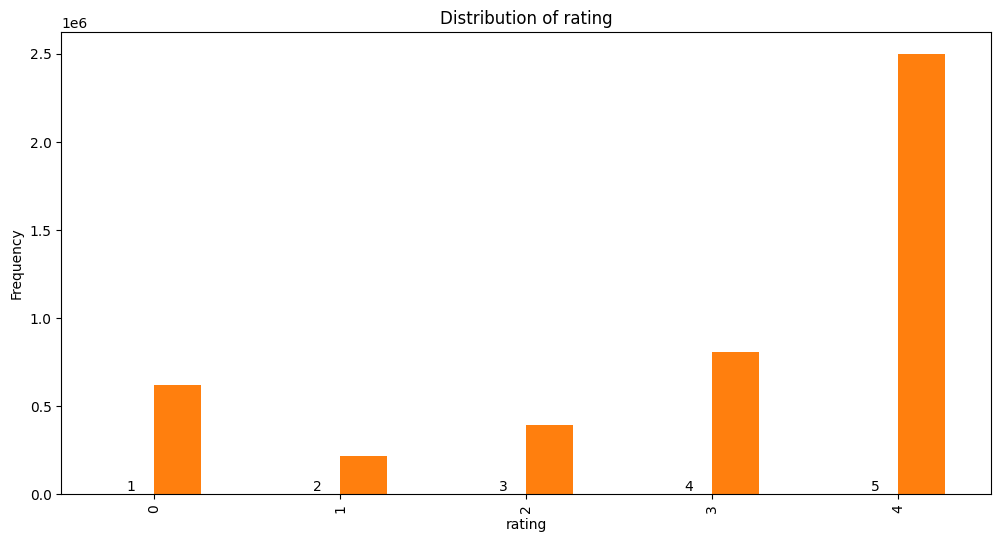

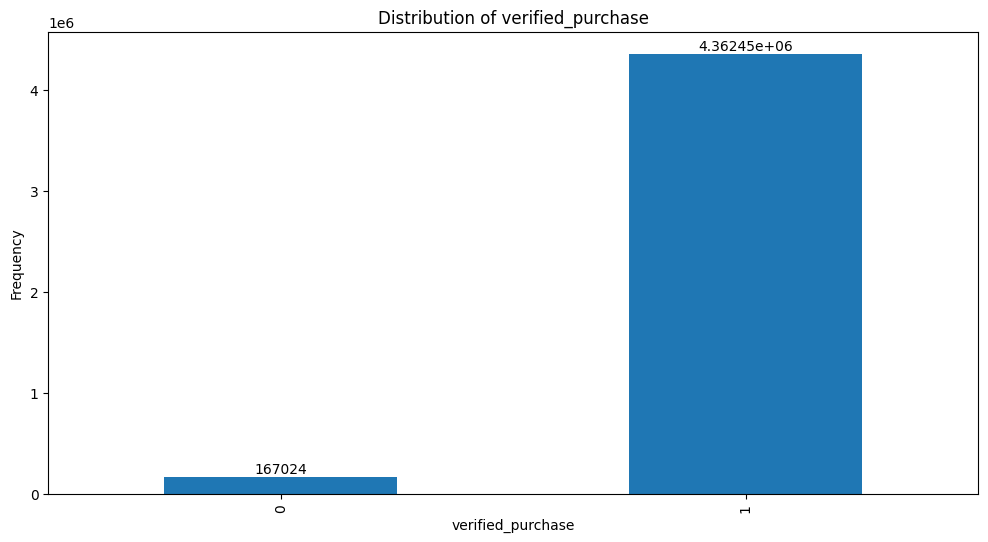

/tmp/ipykernel_30/2152084770.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_length'] = df['text'].apply(len)


<Axes: title={'center': 'Text Length vs Rating'}, xlabel='text_length', ylabel='rating'>

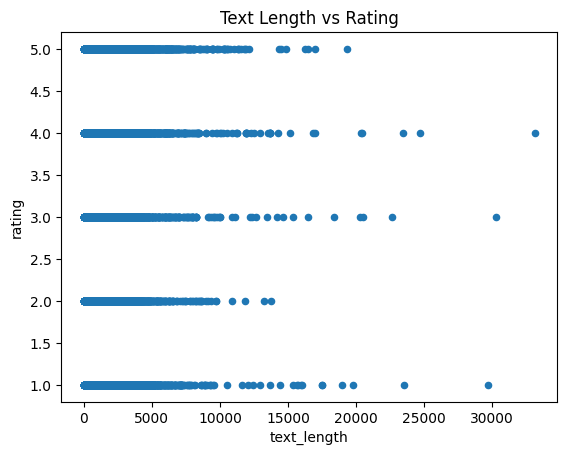

In [94]:
# analyse the distribution of the numerical attributes
def plot_distribution(df, info):
    if info in ['rating', 'verified_purchase']:
        # Calculate the distribution of the specified column
        group_distribution = df[info].value_counts().sort_index()

        # Convert the index to a DataFrame and extract the start of the range for sorting
        group_distribution = group_distribution.reset_index()
        group_distribution.columns = [info, 'count']

        # visualize the distribution
        fig, ax = plt.subplots(figsize=(12, 6))  # Create a figure and axes with desired size
        bars = group_distribution.plot(kind='bar', ax=ax, legend=False)  # Plot the data on the created axes

        # Add labels on top of the bars
        ax.bar_label(bars.containers[0], label_type='edge')

        plt.xlabel(info)
        plt.ylabel('Frequency')
        plt.title(f'Distribution of {info}')
        plt.show()
    
        return group_distribution
    elif info == 'text_length_vs_rating':
        # Do longer reviews give higher or lower ratings
        df['text_length'] = df['text'].apply(len)
        return df.plot.scatter('text_length', 'rating', title='Text Length vs Rating')
        
plot_distribution(filtered_data, 'rating')
plot_distribution(filtered_data, 'verified_purchase')
plot_distribution(filtered_data, 'text_length_vs_rating')

In [95]:
# Find highest rated products
# Calculate the average rating for each product based on parent_asin
average_ratings = filtered_data.groupby('parent_asin')['rating'].mean()

# Retrieve the product with the highest average rating
highest_rated_product = average_ratings.idxmax()
highest_rating = average_ratings.max()

# Retrieve the product with the lowest average rating
lowest_rated_product = average_ratings.idxmin()
lowest_rating = average_ratings.min()

# Display the results
print(f"Highest Rated Product: ASIN = {highest_rated_product}, Average Rating = {highest_rating}")
print(f"Lowest Rated Product: ASIN = {lowest_rated_product}, Average Rating = {lowest_rating}")

Highest Rated Product: ASIN = 0005162092, Average Rating = 5.0
Lowest Rated Product: ASIN = 0028217012, Average Rating = 1.0


### Sample data
Due to the dataset having approximately 4.9 million records. We will sample only 10% for each year. This is to ensure the program is not too computationally expensive to run as well as maintain efficiency and still provides us with enough data to compare and evaluate the sentiment across the years.

In [96]:
random.seed(49)
sampled_df = filtered_data.groupby('year').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)
sampled_df['year'].value_counts()

/tmp/ipykernel_30/2191901147.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = filtered_data.groupby('year').apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)


year
2015    78659
2014    63917
2016    62300
2017    50572
2013    46116
2018    38595
2019    37603
2020    31842
2012    22979
2021    20364
Name: count, dtype: int64

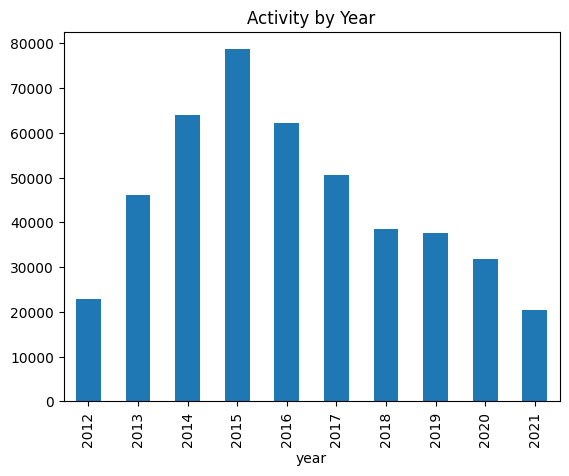

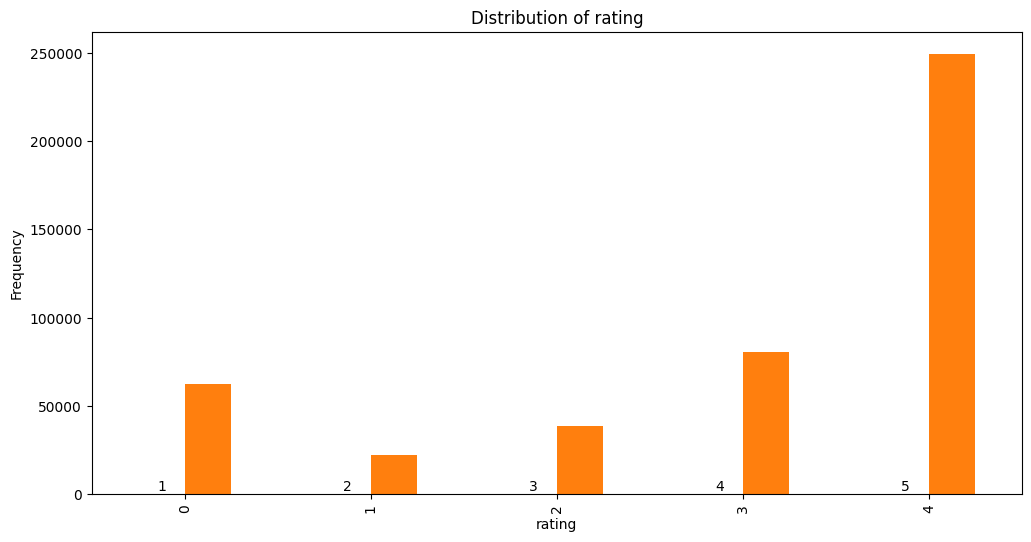

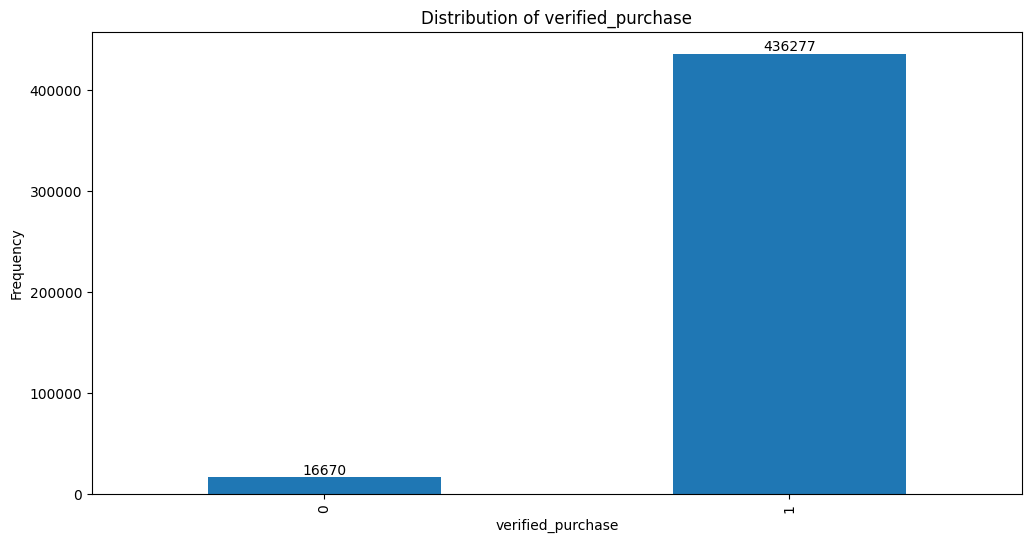

Highest Rated Product: ASIN = 0198612605, Average Rating = 5.0
Lowest Rated Product: ASIN = 0439247926, Average Rating = 1.0


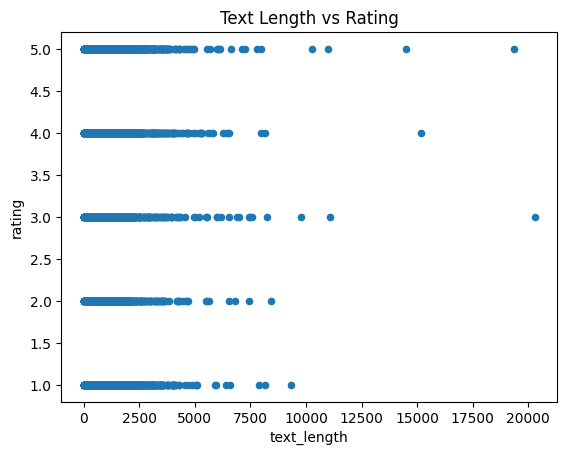

In [97]:
# analyse the distributions again to ensure consistency
plot_timestamp(sampled_df, 'year')
plot_distribution(sampled_df, 'rating')
plot_distribution(sampled_df, 'verified_purchase')
plot_distribution(sampled_df, 'text_length_vs_rating')
# Find highest rated products
# Calculate the average rating for each product based on parent_asin
average_ratings = sampled_df.groupby('parent_asin')['rating'].mean()

# Retrieve the product with the highest average rating
highest_rated_product = average_ratings.idxmax()
highest_rating = average_ratings.max()

# Retrieve the product with the lowest average rating
lowest_rated_product = average_ratings.idxmin()
lowest_rating = average_ratings.min()

# Display the results
print(f"Highest Rated Product: ASIN = {highest_rated_product}, Average Rating = {highest_rating}")
print(f"Lowest Rated Product: ASIN = {lowest_rated_product}, Average Rating = {lowest_rating}")

### Balance the dataset
We also balance the dataset in terms of years to ensure an accurate comparative analysis in done. If we do not balance the dataset, it will lead to us making incorrect or biased conclusions about customer reviews and popular products over the years.

In [98]:
# take 20000 records for each year
n_samples_per_year = 20000

# Create a balanced sample by taking 20,000 records for each year
balanced_sampled_df = sampled_df.groupby('year', group_keys=False).apply(lambda x: x.sample(n=min(len(x), n_samples_per_year)))

# Reset index if needed
balanced_sampled_df.reset_index(drop=True, inplace=True)
balanced_sampled_df['year'].value_counts()

/tmp/ipykernel_30/2599761666.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_sampled_df = sampled_df.groupby('year', group_keys=False).apply(lambda x: x.sample(n=min(len(x), n_samples_per_year)))


year
2012    20000
2013    20000
2014    20000
2015    20000
2016    20000
2017    20000
2018    20000
2019    20000
2020    20000
2021    20000
Name: count, dtype: int64

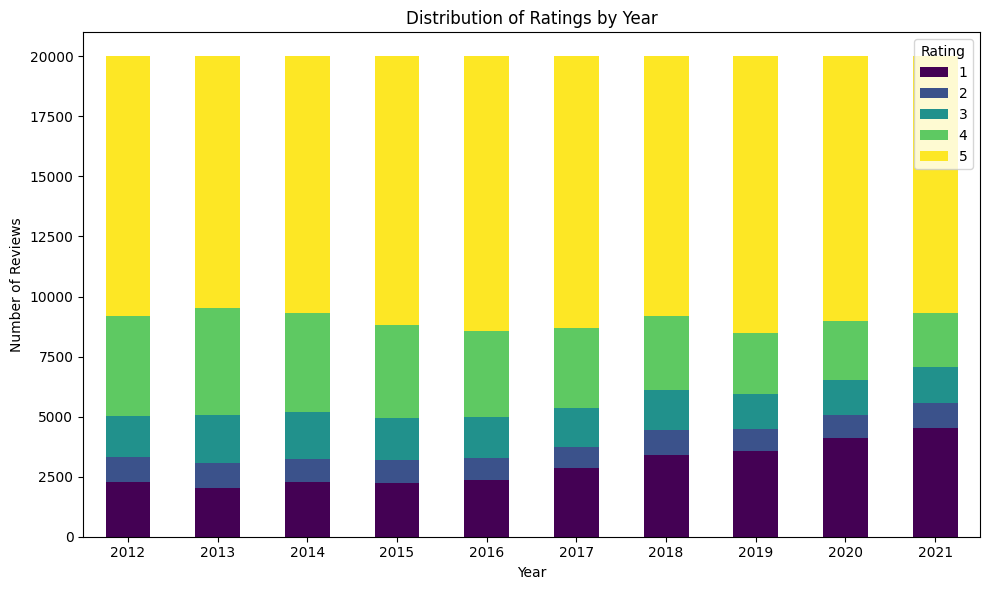

In [99]:
# plot the rating vs the year to analyse how the distribution of ratings were for each year
# we count the occurrences of each rating per year
rating_distribution = balanced_sampled_df.groupby(['year', 'rating']).size().unstack(fill_value=0)

# Plotting
ax = rating_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

# Customize the plot
plt.title('Distribution of Ratings by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)  # Rotate x labels if necessary
plt.legend(title='Rating')
plt.tight_layout()  # Adjust layout
plt.show()

# Sentiment Analysis

We will make use of the **TextBlob** library as well as **NLTK** for performing sentiment analysis on the reviews. Furthermore, we will classify each review according to the sentiment, highlighting whether a specific review is positive, negative, or neutral. Finally, we will present the resuls and analyse how the sentiment changed over the years.

Completed text cleaning for 200000 reviews. [200000/200000] (100.0%)Text cleaning complete for all reviews.
Completed sentiment analysis for 200000 reviews. [200000/200000] (100.0%)Sentiment analysis complete for all reviews.
Classified sentiment for 200000 reviews. [200000/200000] (100.0%)Sentiment classification complete for all reviews.


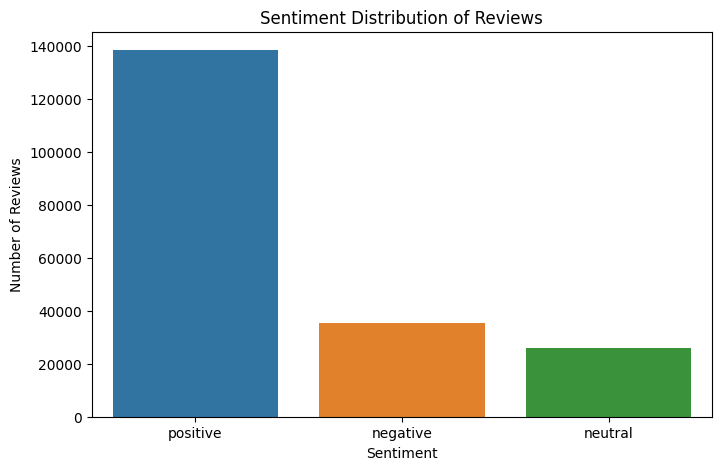

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


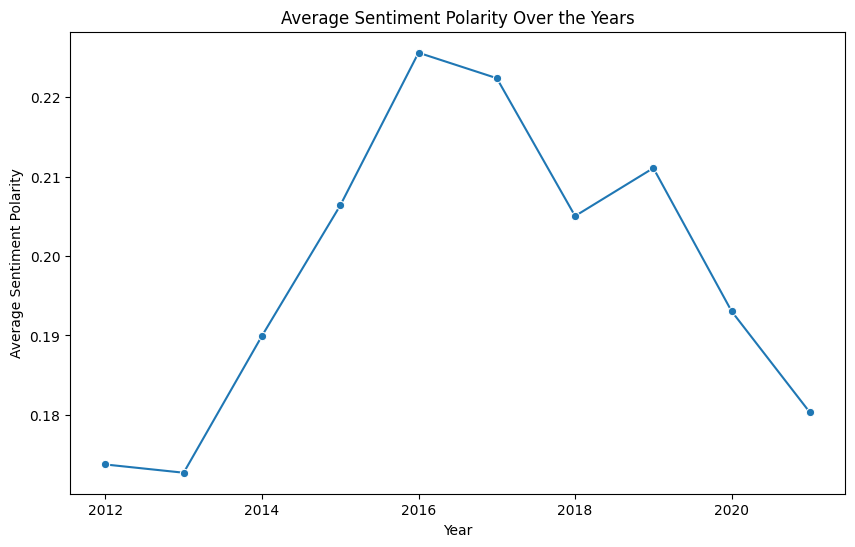

In [104]:
df = balanced_sampled_df.copy()

class SentimentAnaliser:        
    def clean_text(self, df):
        cleaned = []
        all_text = df['text']

        for index, text in enumerate(all_text):
            # Convert to lowercase
            text = text.lower()
            # Remove URLs
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
            # Remove punctuation
            text = text.translate(str.maketrans('', '', string.punctuation))
            # Remove numbers
            text = re.sub(r'\d+', '', text)
            # Remove extra whitespace
            text = re.sub(r'\s+', ' ', text).strip()            
            cleaned.append(text)

            # Print the number of text cleaned
            if (index + 1) % 100 == 0:
                print(f'\rCompleted text cleaning for {index + 1} reviews. [{index + 1}/{df.shape[0]}] ({round((index + 1)/df.shape[0] * 100, 2)}%)', end='')

        # Clean and tokenize the text for the specified column
        df['cleaned_text'] = cleaned
        print('Text cleaning complete for all reviews.')
        return df    

    # Function to get the sentiment polarity
    def get_sentiment(self, df):
        # Initialize a list to store sentiment results
        sentiments = []
        customer_reviews = df['cleaned_text']

        # Iterate over the DataFrame and calculate sentiment for each review
        for index, review in enumerate(customer_reviews):
            analysis = TextBlob(review)

            # Determine the sentiment polarity
            sentiment_score = analysis.sentiment.polarity
            sentiments.append(sentiment_score)

            # Print the number of sentiments completed every 100 iterations (or any other interval)
            if (index + 1) % 100 == 0:
                print(f'\rCompleted sentiment analysis for {index + 1} reviews. [{index + 1}/{df.shape[0]}] ({round((index + 1)/df.shape[0] * 100, 2)}%)', end='')

        # Assign the sentiments back to the DataFrame
        df['sentiment'] = sentiments
        print('Sentiment analysis complete for all reviews.')
        return df

    # Function to classify sentiment based on polarity
    def classify_sentiment(self, df):
        sentiments_classified = []
        sentiment_scores = df['sentiment']

        for index, score in enumerate(sentiment_scores):        
            # Classify sentiment based on polarity score
            if score > 0:
                sentiments_classified.append('positive')
            elif score < 0:
                sentiments_classified.append('negative')
            else:
                sentiments_classified.append('neutral')

            # Print the progress every 100 iterations (or adjust the interval as needed)
            if (index + 1) % 100 == 0:
                print(f'\rClassified sentiment for {index + 1} reviews. [{index + 1}/{df.shape[0]}] ({round((index + 1)/df.shape[0] * 100, 2)}%)', end='')

        df['sentiment_label'] = sentiments_classified
        print('Sentiment classification complete for all reviews.')
        return df
    
    def plot_rating_vs_year(self, df):
        # plot the sentiment vs the year to analyse how the distribution of sentiment were for each year
        # we count the occurrences of each sentiment per year
        rating_distribution = df.groupby(['year', 'sentiment_label']).size().unstack(fill_value=0)

        # Plotting
        ax = rating_distribution.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

        # Customize the plot
        plt.title('Distribution of Ratings by Year')
        plt.xlabel('Year')
        plt.ylabel('Number of Reviews')
        plt.xticks(rotation=0)  # Rotate x labels if necessary
        plt.legend(title='Rating')
        plt.tight_layout()  # Adjust layout
        plt.show()
        
    def plot_sentiment_vs_verification(self, df):
        # Analyze sentiment in terms of verified purchases
        # 1. Create subsets
        verified_purchases = df[df['verified_purchase']]
        non_verified_purchases = df[~df['verified_purchase']]

        # 2. Calculate average polarity scores
        avg_verified = verified_purchases['sentiment'].mean()
        avg_non_verified = non_verified_purchases['sentiment'].mean()

        print(f'Average Polarity Score (Verified Purchases): {avg_verified}')
        print(f'Average Polarity Score (Non-Verified Purchases): {avg_non_verified}')

        # 3. Analyze sentiment label distribution
        verified_distribution = verified_purchases['sentiment_label'].value_counts(normalize=True)
        non_verified_distribution = non_verified_purchases['sentiment_label'].value_counts(normalize=True)

        # 4. Create DataFrame for plotting
        comparison_df = pd.DataFrame({
            'Verified Purchase': verified_distribution,
            'Non-Verified Purchase': non_verified_distribution
        }).fillna(0)  # Fill NaN values with 0 for proper plotting

        # 5. Plot sentiment label distribution
        comparison_df.plot(kind='bar', stacked=True, figsize=(10, 6))
        plt.title('Sentiment Label Distribution for Verified vs Non-Verified Purchases')
        plt.xlabel('Sentiment Label')
        plt.ylabel('Proportion')
        plt.legend(title='Purchase Type')
        plt.xticks(rotation=0)
        plt.show()

        # 6. Plot average polarity scores
        avg_scores = pd.DataFrame({
            'Purchase Type': ['Verified', 'Non-Verified'],
            'Average Polarity Score': [avg_verified, avg_non_verified]
        })

        sns.barplot(data=avg_scores, x='Purchase Type', y='Average Polarity Score', palette='viridis')
        plt.title('Average Polarity Score: Verified vs Non-Verified Purchases')
        plt.ylabel('Average Polarity Score')
        plt.ylim(0, 1)  # Set appropriate y-axis limits
        plt.show()

        # 7. Statistical Testing
        t_stat, p_value = stats.ttest_ind(verified_purchases['sentiment'], non_verified_purchases['sentiment'], equal_var=False)
        print(f'T-statistic: {t_stat}, P-value: {p_value}')

    def perform_sentiment(self, df):
        # clean text
        df = clean_text(df)

        # Apply sentiment analysis and classification to the dataframe
        df = get_sentiment(df)
        df = classify_sentiment(df)

        # Plot sentiment distribution
        sentiment_counts = df['sentiment_label'].value_counts()
        plt.figure(figsize=(8, 5))
        sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
        plt.title('Sentiment Distribution of Reviews')
        plt.xlabel('Sentiment')
        plt.ylabel('Number of Reviews')
        plt.show()

        # Analyze sentiment over time
        sentiment_by_year = df.groupby('year')['sentiment'].mean().reset_index()
        plt.figure(figsize=(10, 6))
        sns.lineplot(x='year', y='sentiment', data=sentiment_by_year, marker='o')
        plt.title('Average Sentiment Polarity Over the Years')
        plt.xlabel('Year')
        plt.ylabel('Average Sentiment Polarity')
        plt.show()
        
# perform sentiment analysis on sampled data
SA_sampled = SentimentAnaliser()
SA_sampled.perform_sentiment(df)

Based on the plot above, we note that the majority of the sampled reviews are positive. When looking at the trends of the sentiment over the years, we note that on average the customer reviews are fairly positive. Furthermore, we observe that there was a significant increase in positive polarity from 2012 to 2015 but then it drop significantly after 2015. This could suggest that previous years have received excellent makreting campaigns and product updates.

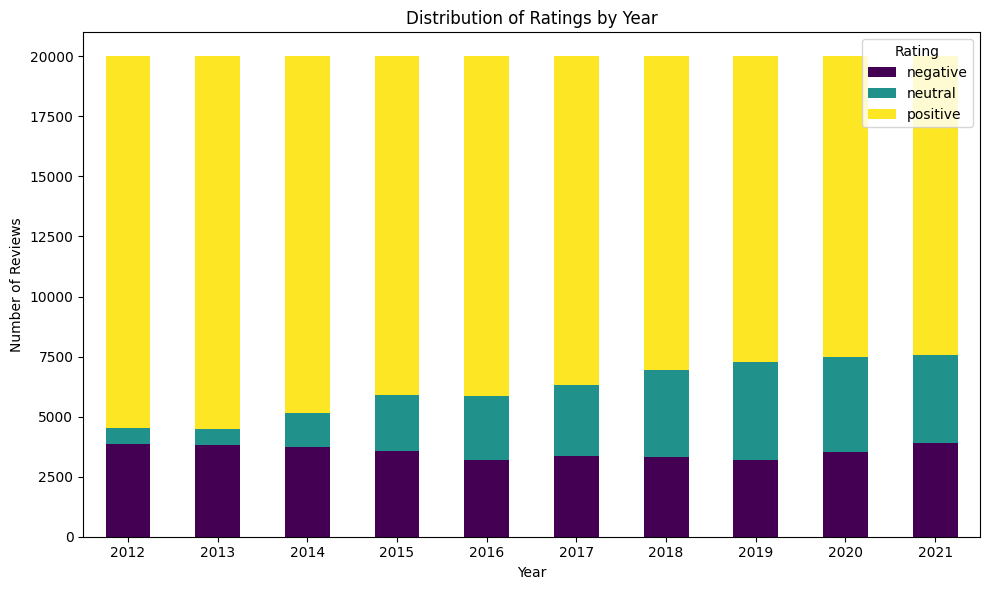

In [105]:
SA_sampled.plot_rating_vs_year(df)

We analyse that the majority of reviews a considered positive. This is supported by the range of polarity scores over the years which ranges from 0.175 to 0.225 which is considered an overall positive sentiment over the years.

Average Polarity Score (Verified Purchases): 0.200546621837198
Average Polarity Score (Non-Verified Purchases): 0.13672718285609048


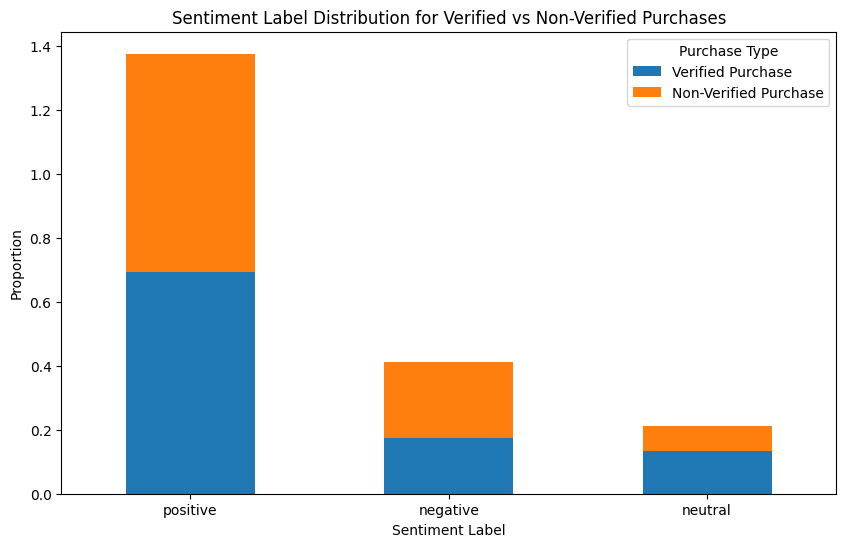

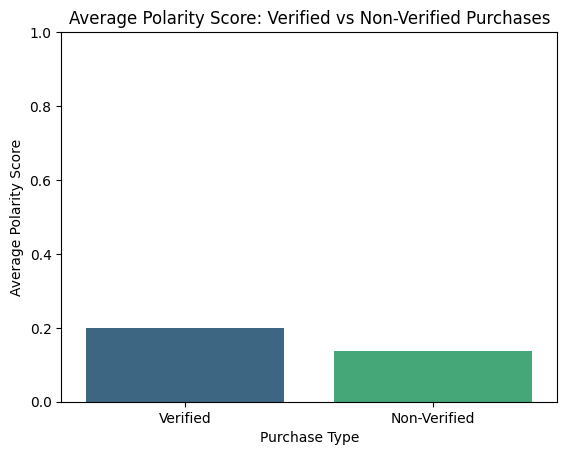

T-statistic: 20.18956036907345, P-value: 1.272808222490445e-88


In [106]:
SA_sampled.plot_sentiment_vs_verification(df)

Based on the results above, whether a purchase is verified or not, the sentiment of the customer's review does not seem to be significantly influenced by it. Due to the p-value being greater than 0.05 we reject our null hypothesis that claimed there is a significant difference between the sentiment and whether a purchase was verfified or not.

### Sentiment for top 10 products
Previously we did an analysis on the overall sentiment of products over a number of years. Now we will analyse the sentiment for the top 10 products.

In [108]:
# top 10 products
merged_df['title_y'].value_counts()[:10]

title_y
Candy Crush Saga           50914
Amazon Prime Video         46940
Minecraft                  44335
Solitaire                  43212
Netflix                    41709
YouTube                    39727
Facebook                   30212
Pluto TV - It’s Free TV    27666
Downloader                 27101
Crossy Road                26870
Name: count, dtype: int64

In [113]:
top10_products = merged_df['title_y'].value_counts().keys()[:10]

In [114]:
# filter the dataset
filtered_top10_df = merged_df[merged_df['title_y'].isin(top10_products)]
filtered_top10_df.shape

(378686, 9)

In [ ]:
# perform sentiment analysis on sampled data
top10_SA_sampled = SentimentAnaliser()
top10_SA_sampled.perform_sentiment(filtered_top10_df)

Completed text cleaning for 378600 reviews. [378600/378686] (99.98%)Text cleaning complete for all reviews.
Completed sentiment analysis for 500 reviews. [500/378686] (0.13%)

/tmp/ipykernel_30/2102496925.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_text'] = cleaned


Completed sentiment analysis for 337900 reviews. [337900/378686] (89.23%)